In [1]:
from warnings import warn

In [2]:
# Standard library imports
import os
from datetime import datetime

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import dill

# Local application imports
from smile.population import Population, PopulationList
from smile.sampling import *
from smile import helper
from smile.global_params import *

In [3]:
#from smile/sampling.py

# Standard library imports
from collections import UserList
from abc import ABC, abstractmethod #abstract base class
from functools import partial #for binding variables to functions

# Third party imports
import numpy as np
import numpy.ma as ma

# Local application imports
from smile.population import Population, PopulationList
from smile import helper
from smile.helper import warn
from smile.global_params import get_MIN, NDAYS, FIRSTVISIT, LASTVISIT
from smile.global_params import _UNREACHED_SMILE, _UNREACHED_MAGNITUDE, _LIMITREACHED, _ALREADYREACHED

In [4]:
# Settings
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
np.random.seed(seed)
np.set_printoptions(edgeitems=30, linewidth=100000)
pickle_dir = 'D:\saved_populations_11'

In [5]:
np.set_printoptions(suppress=True)

In [6]:
# Pickling functions
def dump_to_file(obj, filename, filesuffix='.pik', 
                 dirname=None, create_newdir=False, avoid_overwrite=True):
    #build path
    if dirname is not None: 
        if not os.path.isdir(dirname):
            if create_newdir:
                os.makedirs(dirname)
                print(f"Directory {dirname} was created")
            else:
                raise OSError(f"Directory {dirname} doesn't exist and needs to be created")
        filename = os.path.join(dirname, filename+filesuffix)
    else:
        filename = filename+filesuffix
    #check if will overwrite
    if os.path.isfile(filename) and avoid_overwrite:
        raise OSError(f"File {filename} already exists and would be overwritten")
    else:
        with open(filename, 'wb') as f:
            dill.dump(obj, f, protocol=4)
def load_from_file(filename):
    with open(filename, 'rb') as f:
        return dill.load(f)

In [7]:
# Definitions
#populations
def get_poster_populations(slope_option, error_option, npersons=100, npops=100):
    '''
    returns a PopulationList similar to the one described in the poster
    slope_option is 1, 2, or 3
    error_option is 30/100 or 50/100
    '''
    
    # Define and set visual score function
    pop = Population(npersons, f'poster with {slope_option} and {error_option}')
    gen_visualscores = lambda t,r,v0: np.maximum(-r*t+v0, VMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 0.2
    gen_v0 = lambda shape: np.random.randint(14, 18+1, shape)
    pop.set_parameter_generator('r', gen_r, 'population')
    pop.set_parameter_generator('v0', gen_v0, 'person')

    # Define and set symptom score function
    gen_symptomscores = lambda v,a,s0: np.maximum(a*v+s0, SMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: slope_option
    gen_s0 = lambda shape: np.random.normal(6, 2, shape)
    pop.set_parameter_generator('a', gen_a, 'population')
    pop.set_parameter_generator('s0', gen_s0, 'person')

    # Define and set error functions
    #Multiplicative
    pop.set_score_generator('symptom', lambda s,C: s*C)
    gen_C_mul = lambda shape: np.random.uniform(1-error_option, 1+error_option, shape)
    pop.set_parameter_generator('C', gen_C_mul, 'day')

    # Repeat
    pops = PopulationList.full(npops, pop)
    
    # Return
    return pops
def get_worddoc_populations(slope_option, error_option, npersons=100, npops=100):
    
    # Define and set visual score function
    pop = Population(npersons, title=f'realistic with {slope_option} and {error_option}')
    gen_visualscores = lambda t,r,v0: np.maximum(-r*t+v0, VMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: helper.beta(shape, 0, 2, 0.2, 1.4) #median at 0.4
    gen_v0 = lambda shape: helper.truncatednormal_general(14, 16, 18, 1, shape)
    pop.set_parameter_generator('r', gen_r, 'person')
    pop.set_parameter_generator('v0', gen_v0, 'person')
    
    #Define and set symptom score functions
    gen_symptomscores = lambda v,a: a*(v-VMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: slope_option
    pop.set_parameter_generator('a', gen_a, 'population')
    
    # Define and set error functions
    #Multiplicative
    pop.set_score_generator('symptom', lambda s,C: s*C)
    gen_C_mul = lambda shape: np.random.uniform(1-error_option, 1+error_option, shape)
    pop.set_parameter_generator('C', gen_C_mul, 'day')

    # Repeat
    pops = PopulationList.full(npops, pop)
    
    # Return
    return pops
#simulations
def get_traditional_methodology():
    methodology = Methodology('traditonal')

    first_delay_func = lambda shape: helper.beta(shape, 7, 28, 14, 2.9).astype('int') #90% at 21

    methodology.add_sampler(TraditionalSampler(day=0, delay=first_delay_func))
    methodology.add_sampler(TraditionalSampler(day=('sample', -1), delay=14))
    methodology.add_sampler(TraditionalSampler(day=('sample', -1), delay=14))

    return methodology
def get_realistic_methodology():
    methodology = Methodology('realistic')

    #limit is irrelevant because max(day+delay) < NDAYS
    #if_reached is irrelevant because first sampling method
    first_delay_func = lambda shape: helper.beta(shape, 7, 28, 14, 2.9).astype('int') #90% at 21
    sampler1 = TraditionalSampler(day=0, delay=first_delay_func)
    methodology.add_sampler(sampler1)

    #if_reached is irrelevant because index is previous sample
    other_delay_func = lambda shape: helper.beta(shape, 0, 14, 4, 3.8).astype('int') #90% at 7
    sampler2 = SmileSampler(index=('sample', -1), ratio=0.5, scorename='symptom',
                            delay=other_delay_func, triggered_by_equal=True, min_triggered=2,
                            limit=(LASTVISIT, 'clip'), if_reached='NaN')
    methodology.add_sampler(sampler2)

    #same delay as previous
    sampler3 = MagnitudeSampler(value=2, scorename='symptom',
                                delay=other_delay_func, triggered_by_equal=True, min_triggered=2,
                                limit=(LASTVISIT, 'clip'), if_reached='NaN')
    methodology.add_sampler(sampler3)

    return methodology

In [8]:
#parameters
npersons=1000
npops=1000
slope_options = (1, 2, 3)
error_options = (0.3, 0.5)

In [9]:
np.random.seed(seed)

npops=1
index = 0

if index is not None: 
    suffix='_'+str(index)
    verbose = False
else: 
    suffix=''
    verbose = True

#preallocate arrays
poplists_shape = (len(slope_options), len(error_options))
poster_poplists = np.empty(poplists_shape, dtype=object)
worddoc_poplists = np.empty(poplists_shape, dtype=object)

In [10]:
'''#create and generate
for i, j in np.ndindex(poplists_shape):
    if verbose: print(i, j)
    options = (slope_options[i], error_options[j])
    poster_poplists[i, j] = get_poster_populations(*options, npersons, npops)
    worddoc_poplists[i, j] = get_worddoc_populations(*options, npersons, npops)
    poster_poplists[i, j].generate()
    worddoc_poplists[i, j].generate()

#pickle
dump_to_file(poster_poplists, 'poster_poplists'+suffix, dirname=pickle_dir, create_newdir=True)
dump_to_file(worddoc_poplists, 'worddoc_poplists'+suffix, dirname=pickle_dir)
if verbose: print("Done generation.")


# Filtering

#define
filter_kwargs = {'filter_type':'ratio_early', 'copy':True,
                 'index_day':0, 'recovered_ratio':0.4, 'scorename':'symptom'}

#preallocate arrays
poster_filtered_poplists = np.empty_like(poster_poplists)
worddoc_filtered_poplists = np.empty_like(worddoc_poplists)

#filter
for i, j in np.ndindex(poplists_shape):
    if verbose: print(i, j)
    poster_filtered_poplists[i, j] = poster_poplists[i, j].filter(**filter_kwargs)
    worddoc_filtered_poplists[i, j] = worddoc_poplists[i, j].filter(**filter_kwargs)

#pickle
dump_to_file(poster_filtered_poplists, 'poster_filtered_poplists'+suffix, dirname=pickle_dir)
dump_to_file(worddoc_filtered_poplists, 'worddoc_filtered_poplists'+suffix, dirname=pickle_dir)
if verbose: print("Done filtering.")
    
state = np.random.get_state()
print(state)'''
print()

In [11]:
state = ('MT19937', np.array([2962524577, 1673754294, 1403069053, 3310752670, 2150748404, 1614059452, 2497208348, 1640151344, 3468855398, 3720181135, 1891071198, 1956677444, 4019869901, 2257263567,  162440196, 2896027871,  555007269, 3132089494,  106028734, 2444731365, 2696487513, 3958701767, 2953116324, 1234582482, 3789125954, 3463075842,  294109048, 4204826201, 3617146104, 4045101201, 2755258201, 4127667857, 3696684517, 1208452850, 1208056221, 1045749637, 1596697527, 2772050092, 4288039924, 1435200570,  193151316, 2522991091, 2951580961, 3587302748, 2224023524, 4280287261, 4196025060, 2009477641, 4281943410, 1595652892, 2447706052, 3309857241, 2685832696, 4035670494, 3142604370,  916922574, 2222859523, 4197045632, 1922629509,  460303068, 3157486035, 1537336642, 4053129777,  247110365, 4144466430, 2232095284, 3939371760, 2576373998, 1603351964, 1052312235, 3165573111, 3248186934,  603172881, 2991203459, 1507010990,  658859037, 3998804971, 4283297135, 3929143711, 3332227784,  159059983, 3272388240, 2394159390, 1047738837, 3372245351, 2869973426, 3647313694,  785953559, 1193884913, 2560162864,  125121977, 3933898792, 3147402066, 1083935805, 3183949652, 3075823144,  424169932, 1458051273, 2353087904, 2493346307, 1610737908, 1023045591, 3691117245,  910595644, 2620136404, 1896848137, 1778754715, 1360761329, 3678669641, 3051695931, 2132869126, 3145689170, 2905933491, 1042741354,  401846631,  325388124, 2543504141, 1328618882, 4172701060, 1988443744, 3196167787,  247109501, 2501678380, 3633333619, 2955112146,  159847684, 3751301928, 3905104983, 4251988045, 1498133574, 3193683786,   20590818, 2598381305,  172533427,   91922338, 1130296217,  546489405, 4054577000, 3714128153,  458397046, 1763222388, 3582846067, 4218733163, 2751428247, 3117554187, 2487007324,   50137688, 1311023416, 3703944428, 1915565849, 3021674350, 3950901711, 3231144900,  856493185, 1138515845, 3992657139,  823286758, 4241908457, 2666948650, 3825104051, 2556924563, 2260358832, 3290204568, 2840732707,  798747408,  437653215,  224237832,  727918936, 3990567187, 2582256652, 2310117940, 3752012301,  191213546, 3490914805,  616832337, 3577660776, 3928896522, 1405031918, 2489501508,  748149056, 1798669675, 1066643391,  728029821, 4100582468,  443975640, 4241552582, 3872657472, 1531154470, 2509111327, 3604404577, 3675838967, 1159415143, 1153970042, 3250109838, 3988113558, 1760587973, 1266479929, 2540146897, 2519308032,  773012932, 3247767323, 1487448203, 2522487160,  289182580, 4134348588, 4043692091, 3098759610,  602528582, 3136320525,  657224585, 3190563644, 3629928680,  474995258,  988388115, 2980371030,  304847411, 1523623158, 3599771938, 3299560547, 2144130719,  766376746, 1057584629, 1868584901, 3011282311, 3189475582, 1818760880, 3073194227, 2795354778, 1371194107,  172409568, 3859038954, 2566552990, 1750446490, 1686241969,  604518425, 1939219951, 4099853735, 3839807536,  400270144, 2464469330,  112289859,  276763250, 1634081348,  399122302, 2000116946,  216086402, 3452966769, 1588855574, 3322782230,  574544822, 2490654753,  409212381,  160265617, 3017049346, 3573444927, 1740522960, 2686049101, 1268168538, 2655713465, 3267993503, 4022240039,  804852897, 4216470745, 3417442739, 3643715596, 3767901146, 2760423213, 3289870105, 3099037359, 1602202114, 3218763688, 3248046158, 2302587493, 3433950259, 1637741184, 1897434504,  407705558, 4034163292,  819439911, 2332097103, 3858654421,  873470642, 2735453630, 3096875808, 3325797208, 3907789038, 4161038521, 2889651917, 3816972814, 4176252369, 1170576903, 1023289567, 3384682584, 2454132438, 1772809864, 3232012054,  258664869,   29361161, 3047011742, 2612168855, 4110077122, 1258093998,  485843318, 1543947621, 1579258454, 3280950267, 3181442110, 2693516283, 3027633405,  939778273,  467598849,  481820279,  833565246,  121940299, 3557298006, 1137114277, 2878542548, 3692700970, 3195167106, 2932098987, 2271709511,  124450586, 2837988573, 3343731580, 4087790421, 2149544497, 1976223870, 1029951797, 3028662352, 3996077178,  122305908, 1442086068, 1376730351,  550413091,   19576414, 1806294422, 3985692241, 2688598763, 1881570248, 2712957892, 3896091527,   29345295, 3092670640,  778027226, 3103601603, 1992976343, 3094613427,  757767149,  695296982, 4112843937, 1323920881, 4021047683, 3591571655, 3491965425,  818183058, 1291619059,  651739426, 3648804909,  828520920, 1448496566, 2371212545, 1367110566, 2168314386,  172084378, 2678052721, 3681962451, 3472692927, 2080736518, 4233370017, 1676249706, 2924068216, 1983538652, 1281805945, 2260113446,  959302891, 3374405301, 1037842103, 3705345261,  310580684,    3953313,  196266935, 1035520356, 2703547154,  726563311,  432347905, 3749926353, 1763857169, 1503918235, 3850932828, 1147999315, 3890753832, 3672023121, 2678033133,  948241286, 2504439749, 2770280188,  930828587,  358243772, 2161514302,  837717577,  857475039, 2538739232,  378183472, 2370250179, 1887909332, 3565223139, 1986615431, 1485637523,    4327776, 1976287010,  743098000, 4083083894, 3514648614, 2189986080,  698788302, 1189285076, 2204052099, 3373516581, 3073364029, 4206978005, 4236068855, 2347145695, 2774111166, 1600907130, 1916959399, 3236109786, 3963543818, 2105702810,  329575020, 4280626477, 1406677975, 3609725891,  143530962, 2718747814,  283040834, 2283013549, 1052223275, 1033473294, 2177958675, 1589816008, 2898279465, 3373298705, 1382445692,  239497181, 3156311709,  530127651, 1163969480, 1250063549, 3352918279, 3186410165, 3225879328, 4134636515, 2468392437, 2638035009, 1125790721, 3699499030,  470177812, 1652476610, 2106353707, 1868242572, 2596842009,  768563123,  731126592, 3286590604, 4022795771, 1952073786, 1092644780, 1227240983,  258223923, 2943347620, 3884112101, 2442608769, 3349363935, 2386665317, 3668459484, 1595682394, 1137419649,  713016728, 2271093243, 1177480870,  862085350, 3376267549, 1483115310, 3188758783,  438971434, 2510254426, 2744770629, 3682203590, 3413431247, 1799877235, 3935831478, 2370754455, 1914116326, 1584963998, 2943467219,  279152663, 2786891411, 1801032995, 3019475041, 1707476310, 1383584266, 2059399810, 2348896768, 2611882787, 3301254041, 2672059828,  184265119, 1995976162, 1370574739, 2454464359, 2851498681, 2835628138, 3029051602, 3719053529, 2197887792,  964027880, 3233749272, 3162825811, 1583403689,  298968295, 1804700651, 3214091402, 2484536503, 2130593391, 2996589674,  897206310,  356933663, 1223526713, 3237896562, 2149975732, 2092572945, 3404123592,  990816278, 4192578854,  639249798, 2352662600, 1373524013, 2044931199, 2148934903, 3931691687, 2331301744, 3311943788,  664370375, 2700307854, 4248311467,  805367239, 2148042870, 3179039611, 1813725381,  103693824, 2597638614,  937648497, 1723817120, 4214114431, 3802228538,  293416013, 3870415730, 1753958486, 2768811752, 3048068887, 1958767403, 1499272821, 3870475792, 3207204027, 2749643173, 1033467119, 2982247581,  881776377,   53015050, 3270058793, 2545446936, 1762121894,  392707276,  283103343, 3626883096,  567148963, 2308596262, 2158148095, 2517037061, 3953488342, 2380100455, 1122082151, 2204695252, 2645717296, 3714180060,  818424913, 3944434964, 4212845964,  590085573, 1267185197, 3834012992, 3161683923,  675704302, 1763327952, 1874499649,  775946824, 1325582977,  722539037, 3014031185,  282981467, 3531430042,  667410577, 4102525186, 3286861729, 1144479092, 3051622034,  743370302, 2541324332, 2273963046, 3345702893,  442928778, 2243918487, 4037343766,   87899595, 3646913063, 2858221825,  112127098, 3018166720, 2621981463, 3533239191, 3470380540, 3563258168,  989357537, 3057231140], dtype=np.uint32), 235, 0, 0.0)

In [12]:
poster_filtered_poplists = load_from_file(pickle_dir+"\poster_filtered_poplists_0.pik")
worddoc_filtered_poplists = load_from_file(pickle_dir+"\worddoc_filtered_poplists_0.pik")

In [13]:
np.random.set_state(state)

# Sampling

#create
methodologies = [get_traditional_methodology(), get_realistic_methodology()]

#preallocate arrays
sampled_poplists_shape = (*poplists_shape, len(methodologies))
poster_sampled_poplists = np.empty(sampled_poplists_shape, dtype=object)
worddoc_sampled_poplists = np.empty(sampled_poplists_shape, dtype=object)

In [14]:
poster_sampled_poplists = load_from_file(pickle_dir+"\poster_sampled_poplists_0.pik")
worddoc_sampled_poplists = load_from_file(pickle_dir+"\worddoc_sampled_poplists_0.pik")

In [15]:
'''#sample
for i, j in np.ndindex(poplists_shape):
    if verbose: print(i, j, 'poster', 0)
    poster_sampled_poplists[i, j, 0] = methodologies[0].sample(poster_filtered_poplists[i, j])
    if verbose: print(i, j, 'poster', 1)
    poster_sampled_poplists[i, j, 1] = methodologies[1].sample(poster_filtered_poplists[i, j])
    if verbose: print(i, j, 'poster', 0)
    worddoc_sampled_poplists[i, j, 0] = methodologies[0].sample(worddoc_filtered_poplists[i, j])
    if verbose: print(i, j, 'poster', 1)
    worddoc_sampled_poplists[i, j, 1] = methodologies[1].sample(worddoc_filtered_poplists[i, j])


#pickle
dump_to_file(poster_sampled_poplists, 'poster_sampled_poplists'+suffix, dirname=pickle_dir)
dump_to_file(worddoc_sampled_poplists, 'worddoc_sampled_poplists'+suffix, dirname=pickle_dir)
if verbose: print("Done sampling.")'''
print()

In [16]:
np.random.set_state(state)

methodologies[0].sample(poster_filtered_poplists[0, 0])
methodologies[1].sample(poster_filtered_poplists[0, 0])
methodologies[0].sample(worddoc_filtered_poplists[0, 0])

pop = worddoc_filtered_poplists[0,0][0]
pop.sampling_summary = {'nsamplers':3, 'limit':[], 'if_reached':[]}

:: UserWarning: There are 385 who didn't reach their milestone
:: UserWarning: There are 1000 who didn't reach their milestone
:: UserWarning: There are 390 who had already reached their milestone
:: UserWarning: There are 434 who didn't reach their milestone
:: UserWarning: There are 436 who had already reached their milestone
:: UserWarning: There are 408 who didn't reach their milestone
:: UserWarning: There are 408 who had already reached their milestone
:: UserWarning: There are 411 who didn't reach their milestone
:: UserWarning: There are 411 who had already reached their milestone
:: UserWarning: There are 430 who didn't reach their milestone
:: UserWarning: There are 432 who had already reached their milestone
:: UserWarning: There are 409 who didn't reach their milestone
:: UserWarning: There are 395 who didn't reach their milestone
:: UserWarning: There are 398 who had already reached their milestone
:: UserWarning: There are 458 who didn't reach their milestone
:: UserWarni

In [17]:
methodology = Methodology('realistic')

#limit is irrelevant because max(day+delay) < NDAYS
#if_reached is irrelevant because first sampling method
first_delay_func = lambda shape: helper.beta(shape, 7, 28, 14, 2.9).astype('int') #90% at 21
sampler1 = TraditionalSampler(day=0, delay=first_delay_func)
methodology.add_sampler(sampler1)

#if_reached is irrelevant because index is previous sample
other_delay_func = lambda shape: helper.beta(shape, 0, 14, 4, 3.8).astype('int') #90% at 7
sampler2 = SmileSampler(index=('sample', -1), ratio=0.5, scorename='symptom',
                        delay=other_delay_func, triggered_by_equal=True, min_triggered=2,
                        limit=(LASTVISIT, 'clip'), if_reached='NaN')
methodology.add_sampler(sampler2)

#same delay as previous
sampler3 = MagnitudeSampler(value=2, scorename='symptom',
                            delay=other_delay_func, triggered_by_equal=True, min_triggered=2,
                            limit=(LASTVISIT, 'clip'), if_reached='NaN')
methodology.add_sampler(sampler3)

In [18]:
sampling_days = np.zeros((pop.npersons, 3), dtype=int)

sampler1.sample(pop, 0, sampling_days)
sampler2.sample(pop, 1, sampling_days)
sampler3.sample(pop, 2, sampling_days)

:: UserWarning: There are 15 who didn't reach their milestone
:: UserWarning: There are 29 who didn't reach their milestone


In [19]:
sampling_days_safe = np.where(sampling_days < NDAYS, sampling_days, -1)
sampling_symptoms_safe = np.take_along_axis(pop.scores['symptom'], sampling_days_safe, axis=1)
sampling_symptoms = np.where(sampling_days < NDAYS, sampling_symptoms_safe, np.NaN)

helper.print_collocated([[str(sampling_days), str(sampling_symptoms)]])

[[ 16  25  25]                         		[[ 0.59822375  0.          0.        ] 
 [ 12  22  22]                         		 [ 6.1865454   0.5656842   0.5656842 ] 
 [ 12  56  63]                         		 [ 5.536575    1.788938    1.2009972 ] 
 [ 21  47  56]                         		 [ 4.1785326   2.1194155   1.1696467 ] 
 [ 13  69  91]                         		 [ 7.010695    3.960244    0.9646027 ] 
 [ 14  23  23]                         		 [ 3.1646576   0.          0.        ] 
 [ 10  23  23]                         		 [ 5.496088    0.39640066  0.39640066] 
 [ 12  55  85]                         		 [ 8.493394    4.6842737   1.6293292 ] 
 [ 16  23  23]                         		 [ 1.6995664   0.          0.        ] 
 [ 14  45  51]                         		 [ 5.4323206   2.3277087   1.2816652 ] 
 [ 17  24  24]                         		 [ 2.8348036   0.75852376  0.75852376] 
 [ 11  19  19]                         		 [ 6.8005595   1.3431282   1.3431282 ] 
 [ 18  33  33]              

In [20]:
sampling_days2 = sampling_days.copy()

is_same_day_as_prev = np.zeros_like(sampling_days, dtype=bool)
is_same_day_as_prev[:,1:] = np.diff(sampling_days) == 0 #note first column/sample has no prev so False
alreadyinvalid = sampling_days > LASTVISIT
is_same_day_as_prev = np.logical_and(is_same_day_as_prev, ~alreadyinvalid)

sampler1.set_alreadyreached(pop, 0, sampling_days, is_same_day_as_prev)
sampler2.set_alreadyreached(pop, 1, sampling_days, is_same_day_as_prev)
sampler3.set_alreadyreached(pop, 2, sampling_days, is_same_day_as_prev)

:: UserWarning: There are 82 who had already reached their milestone
:: UserWarning: There are 540 who had already reached their milestone


In [21]:
sampling_days_safe = np.where(sampling_days < NDAYS, sampling_days, -1)
sampling_symptoms_safe = np.take_along_axis(pop.scores['symptom'], sampling_days_safe, axis=1)
sampling_symptoms = np.where(sampling_days < NDAYS, sampling_symptoms_safe, np.NaN)

helper.print_collocated([[str(sampling_days2), str(sampling_days), str(sampling_symptoms)]])

[[ 16  25  25]                         		[[   16    25 65540]                   		[[ 0.59822375  0.                 nan] 
 [ 12  22  22]                         		 [   12    22 65540]                   		 [ 6.1865454   0.5656842          nan] 
 [ 12  56  63]                         		 [   12    56    63]                   		 [ 5.536575    1.788938    1.2009972 ] 
 [ 21  47  56]                         		 [   21    47    56]                   		 [ 4.1785326   2.1194155   1.1696467 ] 
 [ 13  69  91]                         		 [   13    69    91]                   		 [ 7.010695    3.960244    0.9646027 ] 
 [ 14  23  23]                         		 [   14    23 65540]                   		 [ 3.1646576   0.                 nan] 
 [ 10  23  23]                         		 [   10    23 65540]                   		 [ 5.496088    0.39640066         nan] 
 [ 12  55  85]                         		 [   12    55    85]                   		 [ 8.493394    4.6842737   1.6293292 ] 
 [ 16  23  23]          

# Second Sample

2nd sample: needs 2 days in a row, including day before index


(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

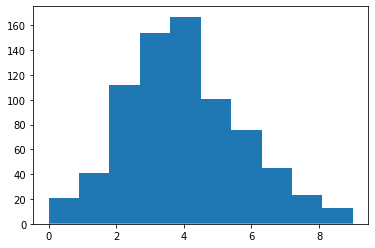

In [31]:
print("2nd sample: needs 2 days in a row, including day before index")

days_reached = []
for i in range(pop.npersons):
    index_day = sampling_days[i,0]
    index_value = sampling_symptoms[i,0]
    trigger_value = index_value * 0.5
    curr_and_future_values = pop.scores['symptom'][i,index_day-1:]
    appended = False
    t1, t2 = False, False
    for j in range(len(curr_and_future_values)):
        t1 = t2
        t2 = curr_and_future_values[j] <= trigger_value
        if t1 and t2: 
            day_reached = index_day-1+j
            if day_reached == index_day:
                days_reached.append(_ALREADYREACHED)
            else:
                days_reached.append(day_reached)
            appended = True
            break
    if not appended:
        days_reached.append(159) #limit

delays = np.array(sampling_days[:,1])-np.array(days_reached)

legal = np.where(sampling_days[:,1] < 160)[0]

plt.hist(delays[legal])

(array([  6.,  55.,  98., 147., 164., 124.,  75.,  56.,  18.,  10.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

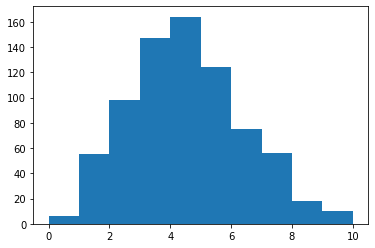

In [35]:
plt.hist(other_delay_func(legal.shape))

# Third Sample

3rd sample: needs 2 days in a row, including day before index


(array([20., 22., 54., 53., 40., 38., 35., 17.,  9.,  7.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

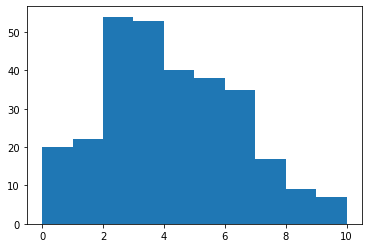

In [29]:
print("3rd sample: needs 2 days in a row, including day before index")

days_reached = []
for i in range(pop.npersons):
    if sampling_days[i,1] == _ALREADYREACHED: 
        index_day = sampling_days[i,0]
        index_value = sampling_symptoms[i,0]
    else:
        index_day = sampling_days[i,1]
        index_value = sampling_symptoms[i,1]
    trigger_value = 2
    curr_and_future_values = pop.scores['symptom'][i,index_day-1:]
    appended = False
    t1, t2 = False, False
    for j in range(len(curr_and_future_values)):
        t1 = t2
        t2 = curr_and_future_values[j] <= trigger_value
        if t1 and t2: 
            day_reached = index_day-1+j
            if day_reached == index_day:
                days_reached.append(_ALREADYREACHED)
            else:
                days_reached.append(day_reached)
            appended = True
            break
    if not appended:
        if index_day == 159:
                days_reached.append(_ALREADYREACHED)
        else:
            days_reached.append(159)

delays = np.array(sampling_days[:,2])-np.array(days_reached)

legal = np.where(sampling_days[:,2] < 160)[0]

plt.hist(delays[legal])

(array([ 50., 123., 146., 150., 117.,  90.,  40.,  30.,   5.,   2.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

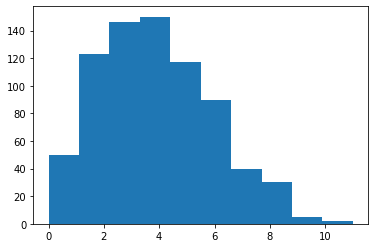

In [48]:
plt.hist(other_delay_func(legal.shape))

# Comparing with simulation

## 3rd sample

In [61]:
poster_filtered_poplists = load_from_file(pickle_dir+"\poster_filtered_poplists_0.pik")
worddoc_filtered_poplists = load_from_file(pickle_dir+"\worddoc_filtered_poplists_0.pik")

In [62]:
poster_sampled_poplists = load_from_file(pickle_dir+"\poster_sampled_poplists_0.pik")
worddoc_sampled_poplists = load_from_file(pickle_dir+"\worddoc_sampled_poplists_0.pik")

In [77]:
pop = worddoc_filtered_poplists[1,1][2].copy()
sampling_days = worddoc_sampled_poplists[1,1,1][2].days.copy()

sampling_days_safe = np.where(sampling_days < NDAYS, sampling_days, -1)
sampling_symptoms_safe = np.take_along_axis(pop.scores['symptom'], sampling_days_safe, axis=1)
sampling_symptoms = np.where(sampling_days < NDAYS, sampling_symptoms_safe, np.NaN)

3rd sample: needs 2 days in a row, including day before index


(array([34., 33., 40., 67., 82., 50., 27., 28., 10.,  3.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

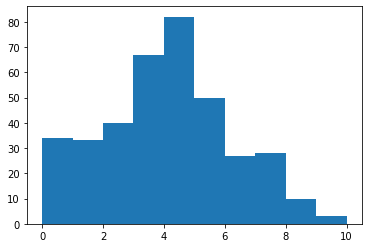

In [97]:
print("3rd sample: needs 2 days in a row, including day before index")

days_reached = []
for i in range(pop.npersons):
    if sampling_days.mask[i,1] == True : 
        index_day = sampling_days[i,0]
        index_value = sampling_symptoms[i,0]
    else:
        index_day = sampling_days[i,1]
        index_value = sampling_symptoms[i,1]
    trigger_value = 2
    curr_and_future_values = pop.scores['symptom'][i,index_day-1:]
    appended = False
    t1, t2 = False, False
    for j in range(len(curr_and_future_values)):
        t1 = t2
        t2 = curr_and_future_values[j] <= trigger_value
        if t1 and t2: 
            day_reached = index_day-1+j
            if day_reached == index_day:
                days_reached.append(_ALREADYREACHED)
            else:
                days_reached.append(day_reached)
            appended = True
            break
    if not appended:
        if index_day == 159:
                days_reached.append(_ALREADYREACHED)
        else:
            days_reached.append(159)

delays = np.array(sampling_days[:,2])-np.array(days_reached)

legal = np.where(np.logical_or(sampling_days[:,2].mask == False, sampling_days[:,1].mask == False))[0]

plt.hist(delays[legal], np.arange(11))

In [164]:
print(np.array(days_reached)[np.where(delays==0)])
print(sampling_days[np.where(delays==0)])

[159 159 159  33 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159  68 159]
[[18 74 159]
 [12 145 159]
 [12 152 159]
 [17 29 33]
 [17 113 159]
 [12 16 159]
 [16 49 159]
 [9 109 159]
 [12 39 159]
 [17 153 159]
 [16 66 159]
 [10 22 159]
 [15 107 159]
 [15 36 159]
 [17 119 159]
 [13 123 159]
 [20 88 159]
 [16 81 159]
 [12 132 159]
 [16 97 159]
 [11 74 159]
 [12 98 159]
 [10 125 159]
 [24 37 159]
 [13 40 159]
 [11 150 159]
 [18 104 159]
 [14 23 159]
 [22 152 159]
 [21 150 159]
 [18 103 159]
 [12 145 159]
 [10 22 68]
 [9 41 159]]


(array([  8.,  51., 108., 147., 140., 118.,  70.,  43.,  19.,   6.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

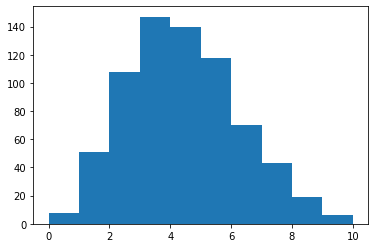

In [156]:
plt.hist(other_delay_func(legal.shape), np.arange(11))